In [1]:
"""
- Projede kullanacağımız kütüphaneleri içe aktarmak.
- Görüntü işleme, model eğitimi ve değerlendirme için gerekli modüller burada yüklenecek.
"""

import os
import shutil
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [7]:
"""
- Veri setinin bulunduğu klasörü tanımlamak
- Eğitim parametrelerini (img size, batch size, seed vb.) tek yerde toplamak
"""

# Kaggle'dan çıkan yol örneği:
# .../state-farm-distracted-driver-detection/imgs/train/c0...c9
DATA_DIR = r"C:\Users\Furkan\OneDrive\Desktop\Dikkatsiz sürücü tespiti\State Farm Distracted Driver Detection\imgs"   S
TRAIN_DIR_10CLASS = os.path.join(DATA_DIR, "train")

# 4 sınıflı yeni veri setini burada oluşturacağız
OUTPUT_DIR_4CLASS = os.path.join(DATA_DIR, "train_4class")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32 # modeli aynı anda 32 görüntüyle eğiteceğiz
SEED = 42

# Train/Val/Test oranları
TRAIN_SPLIT = 0.7
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15

assert abs(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT - 1.0) < 1e-9 #oranların 100½ olmasını kontrol eder kod güvenliği için
print("Train dir:", TRAIN_DIR_10CLASS)
print("Output (4-class) dir:", OUTPUT_DIR_4CLASS)


Train dir: C:\Users\Furkan\OneDrive\Desktop\Dikkatsiz sürücü tespiti\State Farm Distracted Driver Detection\imgs\train
Output (4-class) dir: C:\Users\Furkan\OneDrive\Desktop\Dikkatsiz sürücü tespiti\State Farm Distracted Driver Detection\imgs\train_4class


In [9]:
"""
- Orijinal 10 sınıfı (c0..c9) projeye uygun şekilde 4 ana sınıfa birleştirmek.
"""

CLASS_MAP = {
    "normal": ["c0"],
    "phone": ["c1", "c2", "c3", "c4"],
    "looking_away": ["c7", "c9"],
    "other": ["c5", "c6", "c8"]
}

CLASS_MAP


{'normal': ['c0'],
 'phone': ['c1', 'c2', 'c3', 'c4'],
 'looking_away': ['c7', 'c9'],
 'other': ['c5', 'c6', 'c8']}

In [11]:
"""
- OUTPUT_DIR_4CLASS altında şu yapıyı oluşturmak:
  train_4class/
    normal/
    phone/
    looking_away/
    other/

Not:
- Bu işlem dosyaları kopyalar.
"""

# Eski klasörü temizliyoruz
if os.path.exists(OUTPUT_DIR_4CLASS):
    shutil.rmtree(OUTPUT_DIR_4CLASS)

os.makedirs(OUTPUT_DIR_4CLASS, exist_ok=True)
for new_class in CLASS_MAP.keys():
    os.makedirs(os.path.join(OUTPUT_DIR_4CLASS, new_class), exist_ok=True)

print("4-class klasörleri hazır.")


4-class klasörleri hazır.


In [14]:
"""
- c0..c9 klasörlerindeki görselleri CLASS_MAP'e göre 4 sınıflı klasörlere kopyalamak.
- Böylece Keras ImageDataGenerator ile direkt 4 sınıf üzerinden eğitim yapabileceğiz.
"""

def copy_images_to_4class(src_train_dir, out_dir, class_map, max_per_old_class=None):
   
    total_copied = 0
    
    for new_class, old_classes in class_map.items():
        for old_cls in old_classes:
            old_path = os.path.join(src_train_dir, old_cls)
            images = os.listdir(old_path)
            
            if max_per_old_class is not None:
                images = images[:max_per_old_class]
            
            for img_name in images:
                src = os.path.join(old_path, img_name)
                dst = os.path.join(out_dir, new_class, f"{old_cls}_{img_name}")
                shutil.copy2(src, dst)
                total_copied += 1
    
    return total_copied

copied = copy_images_to_4class(TRAIN_DIR_10CLASS, OUTPUT_DIR_4CLASS, CLASS_MAP)
print("Kopyalanan toplam görsel:", copied)


Kopyalanan toplam görsel: 22424


,count
phone,9256
other,6548
looking_away,4131
normal,2489


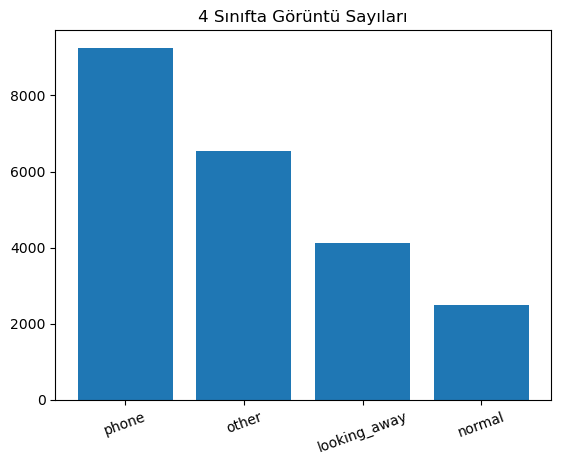

In [16]:

class_counts = {cls: len(os.listdir(os.path.join(OUTPUT_DIR_4CLASS, cls))) for cls in CLASS_MAP.keys()}
df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"]).sort_values("count", ascending=False)
display(df_counts)

plt.figure()
plt.bar(df_counts.index, df_counts["count"])
plt.title("4 Sınıfta Görüntü Sayıları")
plt.xticks(rotation=20)
plt.show()


In [18]:
"""
- Train/Val/Test ayrımı yapmak.
- Keras generator'lar ile ayrı ayrı beslemek için klasör yapısı oluşturacağız.

Çıktı klasörleri:
train_split/
val_split/
test_split/
"""

SPLIT_DIR = os.path.join(DATA_DIR, "split_4class")
TRAIN_OUT = os.path.join(SPLIT_DIR, "train")
VAL_OUT   = os.path.join(SPLIT_DIR, "val")
TEST_OUT  = os.path.join(SPLIT_DIR, "test")

# Temizle ve oluştur
if os.path.exists(SPLIT_DIR):
    shutil.rmtree(SPLIT_DIR)

for base in [TRAIN_OUT, VAL_OUT, TEST_OUT]:
    for cls in CLASS_MAP.keys():
        os.makedirs(os.path.join(base, cls), exist_ok=True)

def split_data(src_dir, train_dir, val_dir, test_dir, train_split=0.7, val_split=0.15, seed=42):
    random.seed(seed)
    for cls in CLASS_MAP.keys():  #burada dengesiz dağılımın önüne geçiyoruz
        imgs = os.listdir(os.path.join(src_dir, cls))
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * train_split)
        n_val = int(n * val_split)
        
        train_imgs = imgs[:n_train]
        val_imgs = imgs[n_train:n_train+n_val]
        test_imgs = imgs[n_train+n_val:]
        
        for img in train_imgs:
            shutil.copy2(os.path.join(src_dir, cls, img), os.path.join(train_dir, cls, img))
        for img in val_imgs:
            shutil.copy2(os.path.join(src_dir, cls, img), os.path.join(val_dir, cls, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(src_dir, cls, img), os.path.join(test_dir, cls, img))
            
    print("Split tamamlandı.")

split_data(OUTPUT_DIR_4CLASS, TRAIN_OUT, VAL_OUT, TEST_OUT, TRAIN_SPLIT, VAL_SPLIT, SEED)


Split tamamlandı.


In [20]:
"""
- Veri ön işleme adımlarını generator üzerinden uygulamak:
  - Resize
  - Normalizasyon / preprocess_input
  - Data augmentation (sadece train için)

Not:
- MobileNetV2 için preprocess_input kullanıyoruz.
"""

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    brightness_range=(0.8, 1.2),
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_OUT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    VAL_OUT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical", 
    seed=SEED,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_OUT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED,
    shuffle=False
)

print("Sınıf indeksleri:", train_gen.class_indices)


Found 15695 images belonging to 4 classes.
Found 3362 images belonging to 4 classes.
Found 3367 images belonging to 4 classes.
Sınıf indeksleri: {'looking_away': 0, 'normal': 1, 'other': 2, 'phone': 3}


In [22]:
"""
-MobileNetV2’yi, daha önce milyonlarca görselle eğitilmiş bir özellik çıkarıcı olarak kullandım.
- Base modeli donduruyoruz (freeze).
- Üste 4 sınıflı yeni sınıflandırıcı ekliyoruz.
"""

base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) #bazı nöronları kapatır
outputs = layers.Dense(4, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
"""
- Modeli eğitmek
- Loss: categorical_crossentropy (çok sınıflı)
- Optimizer: Adam :Adam optimizer, derin öğrenme modellerinde hızlı ve stabil sonuç verdiği için tercih edildi
- Metric: accuracy
"""

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


C:\Users\Furkan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.5157 - loss: 1.1269 - val_accuracy: 0.7136 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.7477 - loss: 0.6532 - val_accuracy: 0.8079 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - accuracy: 0.7832 - loss: 0.5769 - val_accuracy: 0.8162 - val_loss: 0.4908 - learning_rate: 0.0010
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 775s 2s/step - accuracy: 0.7910 - loss: 0.5399 - val_accuracy: 0.8087 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.7955 - loss: 0.5318 - val_accuracy: 0.8287 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.8058 - loss: 0.5071 - val_accuracy: 0.8385 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.8090 - loss: 0

In [26]:
"""

- Eğitilen modelin 'gerçek performansını' görmemiz için test setinde değerlendirme yaptık.
"""

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


C:\Users\Furkan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8442 - loss: 0.4151
Test Loss: 0.3825
Test Accuracy: 0.8545


In [28]:
"""
Amaç:
- Confusion matrix ve classification report için gerçek etiketler (y_true) ve tahminler (y_pred) üretmek.
- test_gen'de shuffle=False olduğu için sıralama bozulmaz ve y_true ile tahminler doğru eşleşir.
"""

import numpy as np

y_true = test_gen.classes  # gerçek sınıf id'leri
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

labels = list(test_gen.class_indices.keys())
print("Sınıf sırası:", labels)


106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 794ms/step
Sınıf sırası: ['looking_away', 'normal', 'other', 'phone']


In [30]:
"""
Amaç:
- Sadece accuracy değil; her sınıf için precision, recall ve F1-score'u görmek.
- Dengesiz veri setlerinde bu metrikler daha anlamlıdır.
"""

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels, digits=4))


              precision    recall  f1-score   support

looking_away     0.8478    0.8519    0.8498       621
      normal     0.8698    0.7861    0.8258       374
       other     0.8323    0.8281    0.8302       983
       phone     0.8690    0.8927    0.8807      1389

    accuracy                         0.8545      3367
   macro avg     0.8547    0.8397    0.8466      3367
weighted avg     0.8544    0.8545    0.8542      3367



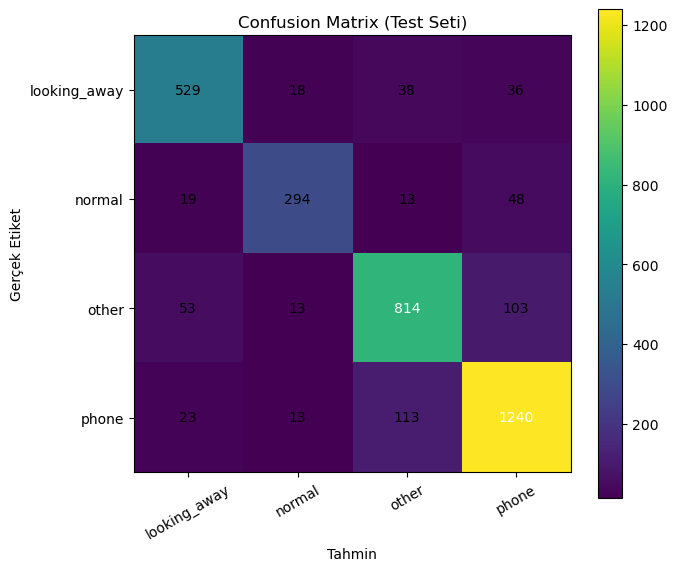

In [32]:
"""
Amaç:
- Hangi sınıfların birbiriyle karıştığını görselleştirmek.
"""

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test Seti)")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=30)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("Gerçek Etiket")
plt.xlabel("Tahmin")
plt.tight_layout()
plt.show()


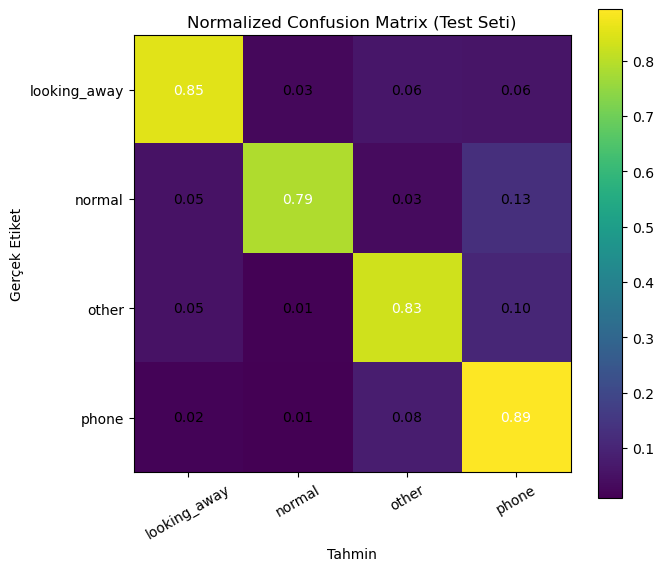

In [34]:
"""
- Her gerçek sınıf için yüzde kaç doğru / yanlış tahmin yapıldığını görmek.
- Dengesiz veri setlerinde normalizasyon daha adil bir görünümdür.
"""

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
plt.imshow(cm_norm, interpolation='nearest')
plt.title("Normalized Confusion Matrix (Test Seti)")
plt.colorbar()
plt.xticks(tick_marks, labels, rotation=30)
plt.yticks(tick_marks, labels)

thresh = cm_norm.max() / 2
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center",
                 va="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.ylabel("Gerçek Etiket")
plt.xlabel("Tahmin")
plt.tight_layout()
plt.show()


In [40]:
# Sınıf isimleri (generator sırasına göre!)
class_names = ['looking_away', 'normal', 'other', 'phone']


In [42]:
"""

- Tek bir görüntüyü modele uygun hale getirip tahmin almak
"""

from tensorflow.keras.preprocessing import image
import numpy as np

def predict_single_image(img_path, model, img_size=(224, 224)):
    
    img = image.load_img(img_path, target_size=img_size)
    
    
    img_array = image.img_to_array(img)
    
    
    img_array = np.expand_dims(img_array, axis=0)
    
    
    img_array = img_array / 255.0
    
    # Tahmin
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    
    return class_names[pred_index], preds[0]


In [44]:
"""
Amaç:
- 4 farklı fotoğraf üzerinde model tahminlerini görmek
"""

import os

demo_dir = "demo_images"

for img_name in os.listdir(demo_dir):
    img_path = os.path.join(demo_dir, img_name)
    
    predicted_class, probabilities = predict_single_image(img_path, model)
    
    print(f"Görsel: {img_name}")
    print(f"→ Tahmin Edilen Sınıf: {predicted_class}")
    print(f"→ Olasılıklar: {probabilities}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Görsel: img1.jpg
→ Tahmin Edilen Sınıf: other
→ Olasılıklar: [0.07027446 0.00150977 0.9227703  0.00544551]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Görsel: img2.jpg
→ Tahmin Edilen Sınıf: looking_away
→ Olasılıklar: [9.9995196e-01 1.5584596e-05 2.7615704e-05 4.7950011e-06]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Görsel: img3.jpg
→ Tahmin Edilen Sınıf: looking_away
→ Olasılıklar: [0.9212477  0.03448817 0.0196867  0.02457747]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Görsel: img4.jpg
→ Tahmin Edilen Sınıf: phone
→ Olasılıklar: [3.0688041e-01 1.4623045e-04 6.6088915e-02 6.2688446e-01]
--------------------------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


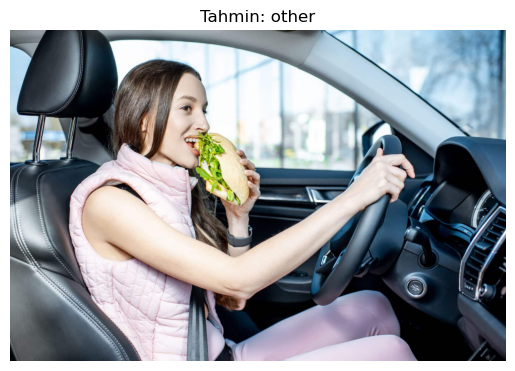

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


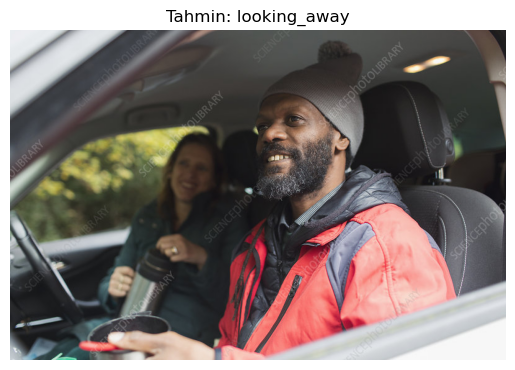

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


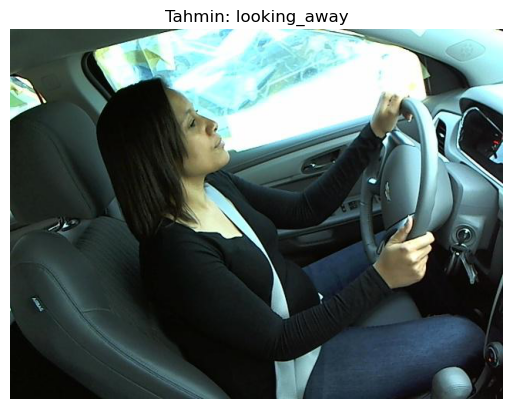

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


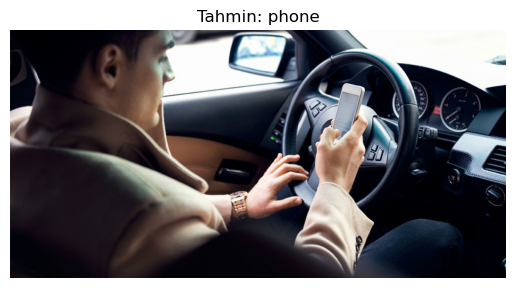

In [46]:
import matplotlib.pyplot as plt

def show_prediction(img_path, predicted_class):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Tahmin: {predicted_class}", fontsize=12)
    plt.show()

for img_name in os.listdir(demo_dir):
    img_path = os.path.join(demo_dir, img_name)
    predicted_class, _ = predict_single_image(img_path, model)
    show_prediction(img_path, predicted_class)